# Sensitivity check with Iris Data

In [1]:
pip install torchhk

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
from torchhk.vis import plot_individual_weight

## Dataset & Preprocessing

### Load Dataset

In [3]:
iris = pd.read_csv('../dataset/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris.shape

(150, 5)

### Label Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
iris['species'] = encoder.fit_transform(iris['species'])

### Feature Selection

In [6]:
X = iris.drop('species', axis=1).values
Y = iris['species'].values 

### Torch 변환

In [7]:
x, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
x.shape, y.shape

(torch.Size([150, 4]), torch.Size([150]))

## Define Model

In [8]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

## Train Model

### 1. Sensitivity to KL loss

In [13]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=4, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=100, out_features=3),
)

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
kl_weight = 0.1

In [15]:
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f'Epoch {step}: | Loss: {cost}')
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

Epoch 0: | Loss: tensor([2.5775], grad_fn=<AddBackward0>)
Epoch 100: | Loss: tensor([0.6422], grad_fn=<AddBackward0>)
Epoch 200: | Loss: tensor([0.4817], grad_fn=<AddBackward0>)
Epoch 300: | Loss: tensor([0.5128], grad_fn=<AddBackward0>)
Epoch 400: | Loss: tensor([0.4629], grad_fn=<AddBackward0>)
Epoch 500: | Loss: tensor([0.4423], grad_fn=<AddBackward0>)
Epoch 600: | Loss: tensor([0.4843], grad_fn=<AddBackward0>)
Epoch 700: | Loss: tensor([0.4494], grad_fn=<AddBackward0>)
Epoch 800: | Loss: tensor([0.4474], grad_fn=<AddBackward0>)
Epoch 900: | Loss: tensor([0.4545], grad_fn=<AddBackward0>)
Epoch 1000: | Loss: tensor([0.4588], grad_fn=<AddBackward0>)
Epoch 1100: | Loss: tensor([0.4534], grad_fn=<AddBackward0>)
Epoch 1200: | Loss: tensor([0.4443], grad_fn=<AddBackward0>)
Epoch 1300: | Loss: tensor([0.4451], grad_fn=<AddBackward0>)
Epoch 1400: | Loss: tensor([0.4572], grad_fn=<AddBackward0>)
Epoch 1500: | Loss: tensor([0.4496], grad_fn=<AddBackward0>)
Epoch 1600: | Loss: tensor([0.4498],

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/torchhk/vis/_model.py:139: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, ax=ax, **kwargs)
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/torchhk/vis/_model.py:139: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

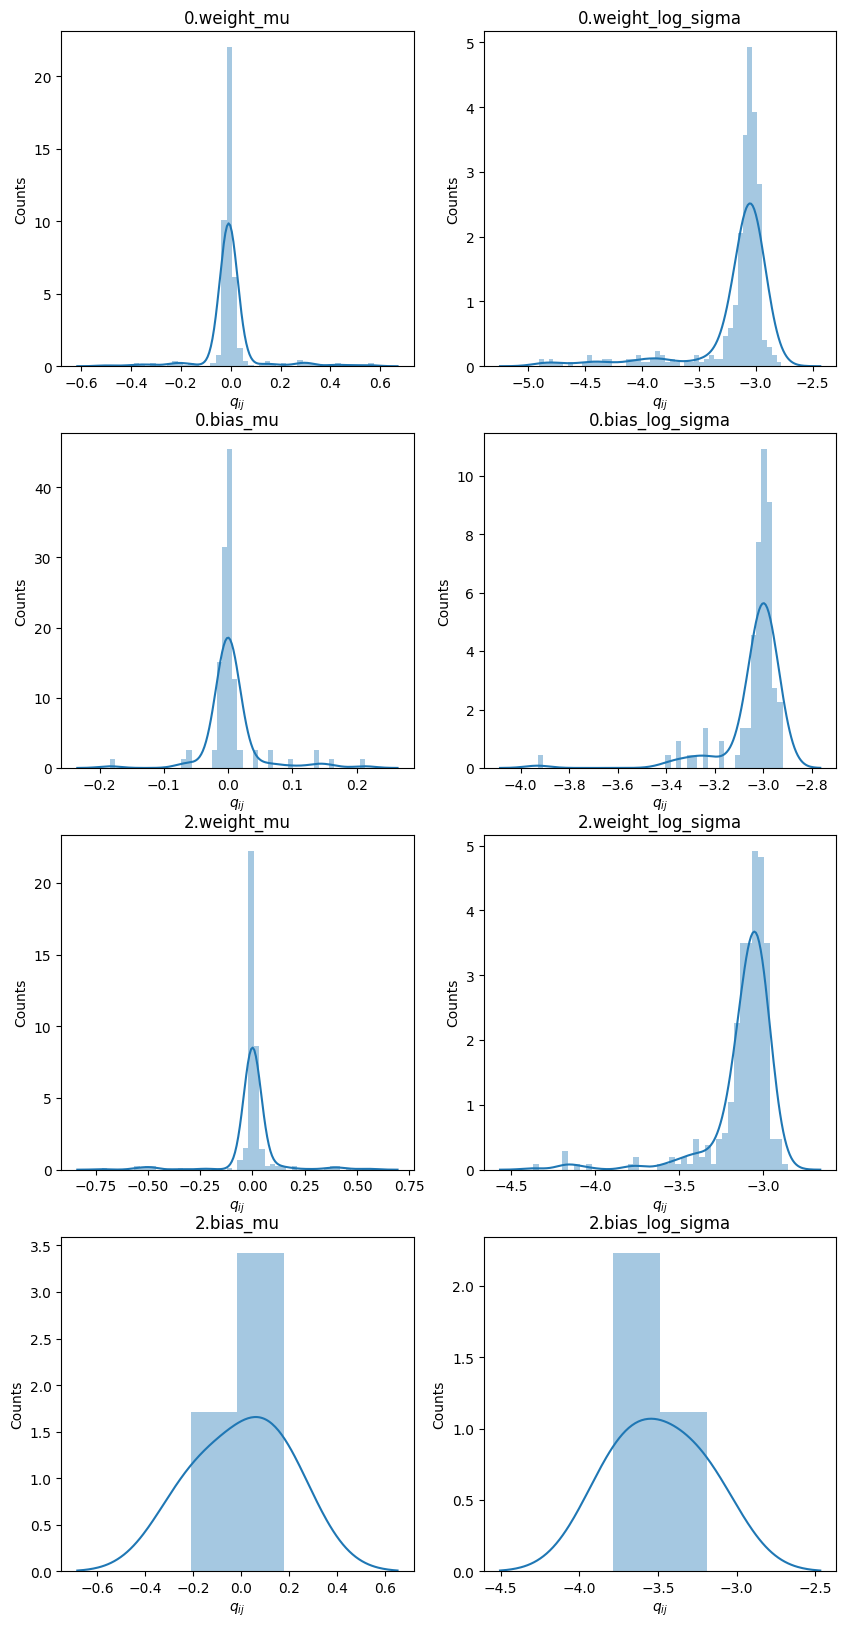

In [10]:
plot_individual_weight(model)

### 2. Custom KL loss

In [16]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=4, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=100, out_features=3),
)

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
def custom_kl_loss(mu_0, log_sigma_0, mu_1, log_sigma_1) :
    kl = (log_sigma_0**2 + (mu_0-mu_1)**2)/(2*log_sigma_1**2)
    return kl.sum()

In [18]:
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    
    # custom kl loss
    ckl = 0
    n = 0
    
    for m in model.modules() :
        if isinstance(m, (bnn.BayesLinear, bnn.BayesConv2d)):
            kl = custom_kl_loss(m.weight_mu, m.weight_log_sigma,
                                m.prior_mu, m.prior_log_sigma)
            ckl += kl
            n += len(m.weight_mu.view(-1))

            if m.bias :
                kl = custom_kl_loss(m.bias_mu, m.bias_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl
                n += len(m.bias_mu.view(-1))

        if isinstance(m, bnn.BayesBatchNorm2d):
            if m.affine :
                kl = custom_kl_loss(m.weight_mu, m.weight_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl
                n += len(m.weight_mu.view(-1))

                kl = custom_kl_loss(m.bias_mu, m.bias_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl                
                n += len(m.bias_mu.view(-1))
    
    cost = ce + kl_weight*ckl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f'Epoch {step}: | Loss: {cost}')
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

Epoch 0: | Loss: 42.134376525878906
Epoch 100: | Loss: 21.80388832092285
Epoch 200: | Loss: 10.886896133422852
Epoch 300: | Loss: 7.9602813720703125
Epoch 400: | Loss: 6.602462291717529
Epoch 500: | Loss: 4.590688228607178
Epoch 600: | Loss: 4.187739372253418
Epoch 700: | Loss: 5.204361915588379
Epoch 800: | Loss: 3.865144968032837
Epoch 900: | Loss: 4.024974346160889
Epoch 1000: | Loss: 5.02793550491333
Epoch 1100: | Loss: 3.9116108417510986
Epoch 1200: | Loss: 3.675870895385742
Epoch 1300: | Loss: 3.277557849884033
Epoch 1400: | Loss: 3.226210832595825
Epoch 1500: | Loss: 3.4754655361175537
Epoch 1600: | Loss: 2.6579301357269287
Epoch 1700: | Loss: 3.0087690353393555
Epoch 1800: | Loss: 3.6666955947875977
Epoch 1900: | Loss: 3.162527084350586
Epoch 2000: | Loss: 3.4515256881713867
Epoch 2100: | Loss: 2.552227258682251
Epoch 2200: | Loss: 2.612792730331421
Epoch 2300: | Loss: 2.91263747215271
Epoch 2400: | Loss: 3.8813772201538086
Epoch 2500: | Loss: 3.0092175006866455
Epoch 2600: | L

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/torchhk/vis/_model.py:139: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, ax=ax, **kwargs)
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/torchhk/vis/_model.py:139: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

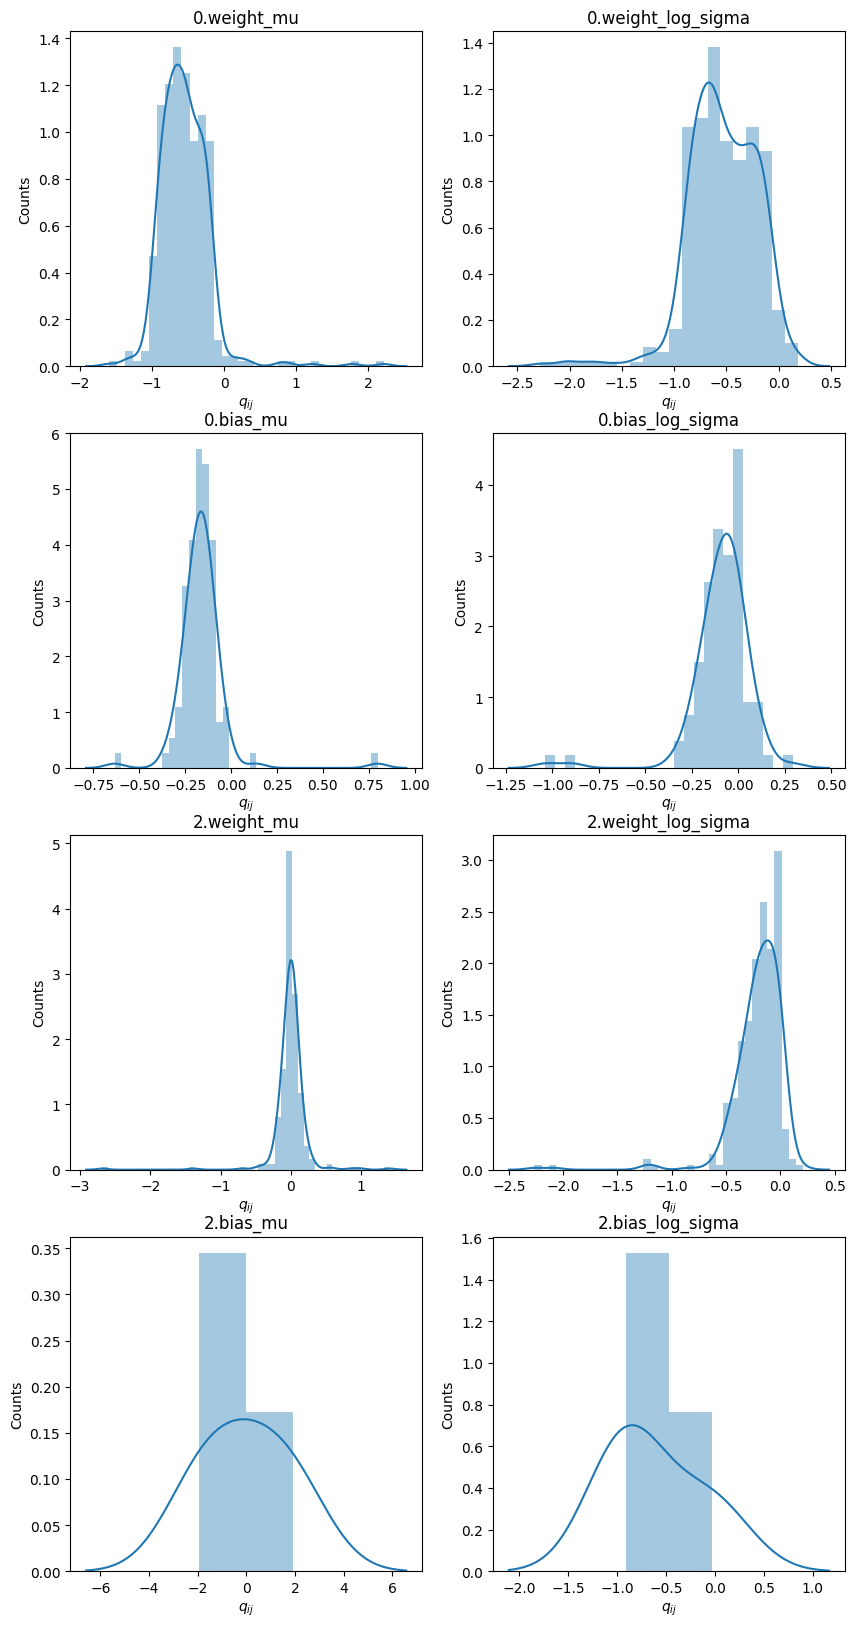

In [19]:
plot_individual_weight(model)